AttributeError: module 'matplotlib' has no attribute 'animation'

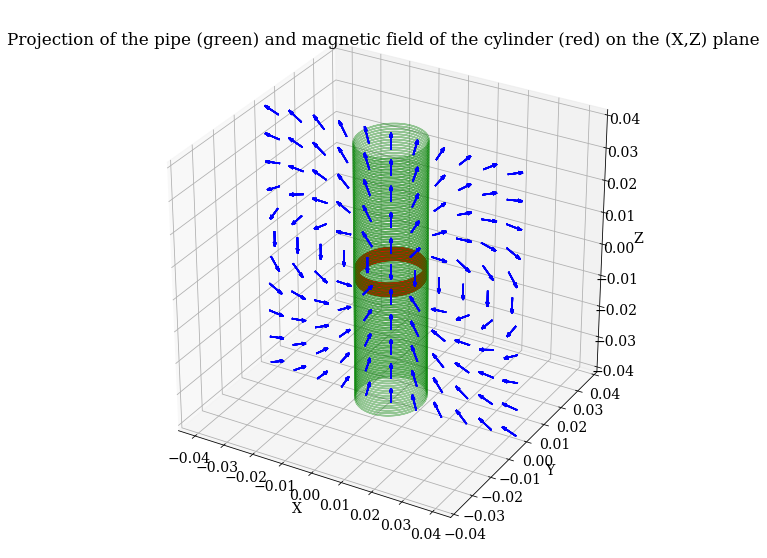

In [5]:

from __future__ import division
from time import time

from sympy import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.integrate import dblquad, nquad, simps
from scipy import constants
from scipy import interpolate
from mpl_toolkits.mplot3d import axes3d

%matplotlib inline


fsize = 20
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'serif'

init_printing()

rho = 7400  # (kg/m**3) density of neodymium the magnet is assumed to be made of
M = 1e6  # magnetization of the neodymium cylinder (in A/m)

a = 0.01  # radius of the cylinder (in m)
L = 0.002  # height of the cylinder (in m)

B0 = -constants.mu_0/(4*np.pi)*M  # this is the constant in the above equations

dwl = 0.001  # diameter (in m) of wire's cross section
rwl = a + 0.5*dwl  # radius (in m) of the wire loop through which the magnet is falling
rhom = 1.68e-8  # (Om*m) the resistivity of copper
z0 = 0.  # initial z coordinate (in m) of the magnet over the wire loop
zwl = 0.2  # z coordinate (in m) of wire loop's position on the pipe


# These are the integrands in the above equations

def funcBz(phi, R):
    return (R*(0.5*L - z)/(R**2 + (0.5*L - z)**2 + r**2 - 2*R*r*np.cos(phi))**1.5 +
            R*(0.5*L + z)/(R**2 + (0.5*L + z)**2 + r**2 - 2*R*r*np.cos(phi))**1.5)


def funcBr(phi, R):
    return (-R*(r - R*np.cos(phi))/(R**2 + (0.5*L - z)**2 + r**2 - 2*R*r*np.cos(phi))**1.5 +
            R*(r-R*np.cos(phi))/(R**2 + (0.5*L + z)**2 + r**2 - 2*R*r*np.cos(phi))**1.5)


# Cartesian coordinate grid for a projection of the magnetic field and pipe on the (X,Z) plane

la = 4 # a half of the size of the plotted domain (cube) in units of a
L2 = la*a # same in m
n = 11 # number of mesh points along each of the coordinate axes
nm = int(n/2)

xx = np.linspace(-L2, L2, n)
# yy = np.linspace(-L2, L2, n) # yy is needed only for a 3d plot
zz = np.linspace(-L2, L2, n)

# to plot a projection on the (X,Z) plane 
yy = np.linspace(0, 0, n)

bx = np.zeros((n, n, n), dtype=float)
by = np.zeros((n, n, n), dtype=float)
bz = np.zeros((n, n, n), dtype=float)

# find z and r components of the magnetic field in the cylindrical coordiantes and transform them to
# x, y, and z components in the Cartesian coordinate system
# for this, we compute the above integrals using nquad or dblquad functions from scipy.integrate

t = time()

maxerz = 0.
maxfz = 0.
maxerr = 0.
maxfr = 0.

for i in range(n):
    x = xx[i]
    for j in range(n):
        y = yy[j]
        r = np.sqrt(x**2+y**2)
        alpha = np.arctan2(y, x)
        for k in range(n):
            z = zz[k]
            fz = nquad(funcBz, [[0, 2*np.pi], [0, a]])
            fr = nquad(funcBr, [[0, 2*np.pi], [0, a]])
            #fz=dblquad(funcBz, 0, a, lambda phi: 0, lambda phi: 2*np.pi)
            #fr=dblquad(funcBr, 0, a, lambda phi: 0, lambda phi: 2*np.pi)
            Br = B0*fr[0]
            bx[i, j, k] = Br * (np.cos(alpha))
            by[i, j, k] = Br * (np.sin(alpha))
            bz[i, j, k] = B0 * fz[0]

            # find maximum errors of the integration for the z and r components
            if abs(fz[0]) > 0.:
                erz = abs(fz[1]/fz[0])
            else:
                erz = 0.
            if erz > maxerz:
                maxerz = erz
                maxfz = fz[0]

            if abs(fr[0]) > 0.:
                err = abs(fr[1]/fr[0])
            else:
                err = 0.
            if err > maxerr:
                maxerr = err
                maxfr = fr[0]

xx, yy, zz = np.meshgrid(xx, yy, zz)


# 3d figure of the (X,Z) projection
fig = plt.figure()
ax = fig.gca(projection='3d')
fig.set_size_inches(10, 10)

# or its projection on the (X,Z) plane

# TO GET A GOOD PLOT TRY ONE OF THESE COMMANDS
# ax.quiver(xx,yy,zz,bx[:,nm,:],by[:,nm,:],bz[:,nm,:],color='b',length=0.5*a,pivot='middle')
ax.quiver(xx, yy, zz, bx[:, nm, :], by[:, nm, :], bz[:, nm, :],
          normalize=True, color='b', length=0.5*a, pivot='middle')

# Plot the magnetic cylinder surrounded by a pipe


def cylinder(r):
    beta = np.linspace(-2*np.pi, 2*np.pi, 100)
    x = r*np.cos(beta)
    y = r*np.sin(beta)
    return x, y


cx, cy = cylinder(a)
cx2, cy2 = cylinder(rwl)

for i in np.linspace(-L, L, 100):
    ax.plot(cx, cy, i, label='Cylinder', color='r', alpha=0.8)

for i in np.linspace(-L2, L2, 100):
    ax.plot(cx2, cy2, i, label='Pipe', color='g', alpha=0.4)
    
plt.title('Projection of the pipe (green) and magnetic field of the cylinder (red) on the (X,Z) plane')
ax.set_ylim([-L2, L2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.show()

